## Ronald Asseko-Messa, Data Scientist
## Analyzing the housing market from Ames, IA

Today let’s talk about a project that I worked on recently: Ames Housing dataset. The project looked at information from the Ames Assessor’s office in Iowa from 2006 to 2010 using different statistical modeling techniques to predict housing prices. The model is then submitted to a Kaggle competition where it is scored based on the root mean square error metric. Here we're using three models, OLS, RidgeCV, and LassoCV.

                         House located in Northridge Heights, Ames, IA

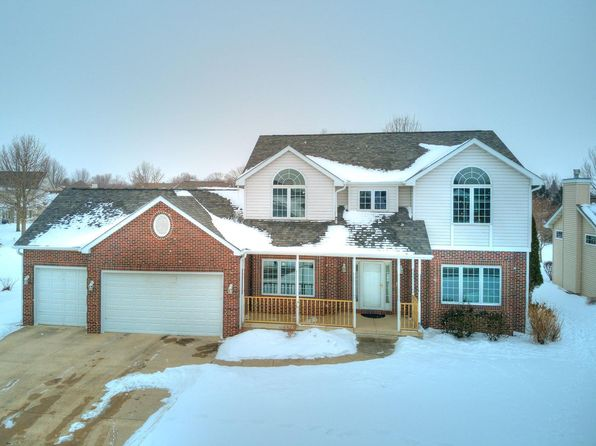





### Problem Statement
Which features of a house can best predict its price?

### Data Dictionary

Here are 22 variables (out of 81 and 2051 observations) I used to perform my analysis:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**saleprice**|*float*|AmesHousing|the property's sale price in dollars| 
|**overall_qual**|*float*| AmesHousing|Rates the overall material and finish of the house| 
|**neighborhood_high**|*float*| AmesHousing|neighborhood with sales price above 75th precentile| 
|**gr_liv_area**|*float*|AmesHousing| Above grade (ground) living area square feet| 
|**garage_area**|*float*| AmesHousing| Size of garage in square feet| 
|**garage_cars**|*float*| AmesHousing|Size of garage in car capacity| 
|**total_bsmt_sf**|*float*|AmesHousing|Total square feet of basement area| 
|**year_remod/add**|*float*|AmesHousing|Remodel date (same as construction date if no remodeling or additions)| 
|**1st_flr_sf**|*float*|AmesHousing|First Floor square feet| 
|**year_built**|*float*|AmesHousing|Original construction date| 
|**full_bath**|*float*|AmesHousing|Basement full bathrooms| 
|**garage_yr_blt**|*float*|AmesHousing|Year garage was built| 
|**mas_vnr_area**|*float*|AmesHousing|Masonry veneer area in square feet| 
|**totrms_abvgrd**|*float*|AmesHousing|Total rooms above grade (does not include bathrooms)| 
|**fireplaces**|*float*|AmesHousing|Number of fireplaces| 
|**bsmtfin_sf_1**|*float*|AmesHousing|Type 1 finished square feet| 
|**lot_frontage**|*float*|AmesHousing|Linear feet of street connected to property| 
|**open_porch_sf**|*float*|AmesHousing|Open porch area in square feet| 
|**wood_deck_sf**|*float*|AmesHousing|Wood deck area in square feet| 
|**renovated**|*float*|AmesHousing|Number of years between the year of sale and the last renovation/addition| 
|**neighborhood_very_low**|*float*|AmesHousing|neighborhood with sale price below 25th percentile| 
|**house_age**|*float*|AmesHousing|age of the house when sold| 

I have a background in economics and statistics, from which I developed a strong interest in the science of data. From that perspective I use econometric research and machine learning models here to explore the data and make recommendations. 

### Loading the packages

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, RidgeCV 
from sklearn.linear_model import Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

### Loading the data

In [160]:

# loading train data
train_data = pd.read_csv('./datasets/train.csv')

#transform the variables to lower cases and replace spaces with _
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')

#looking at the first 5 rows
train_data.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [161]:
# uncomment to see all the column names, their type (numerical or string), and how many non missing values 
# train_data.info()

### Exploratory Data Analysis (EDA)

From litterature reviews, along with common knowledge about houses, the basic idea is that prices are affected by their size, location, and nearby amenities. In other words, the larger the house, the more expensive it is, ceteris paribus (all else being equal). Similar approach between the location and sales price. We'd expect a house located in a well maintained neighborhood (i.e. good schools, access to amenities ...) to be more expensive than one that is relatively not, all else being equal. I also expect other factors like number of rooms, quality of the house and its age to affect sales price. Let's dive into further analysis.

In [162]:
# here are the number of observations, and columns, respectively
train_data.shape

(2051, 81)

We have 2051 rows and 81 columns. Let's now look at the Sale Price, which is our dependent variable.

In [163]:
# descriptive statistics of sale price
train_data['saleprice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

Here is the sales price distribution along with the top and bottom 5 locations by neighborhood.

The right skewed distribution (very close to a normal distribution) bellow shows extreme values above 300,000 USD, which is above the 75th percentile (> $214k). To deal with those extreme values, I take the log of `saleprice`, which normalizes the data and brings it to a percentage change level.

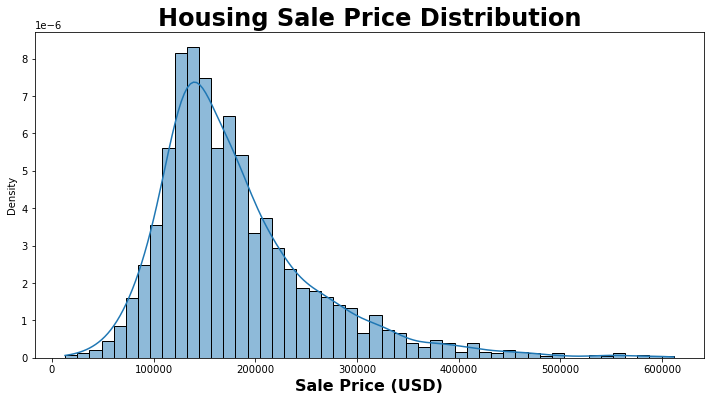

In [164]:
# The histograme shows a right-skew distribution
fig, ax =  plt.subplots(figsize=(12, 6))

sns.histplot(train_data.saleprice, bins=50, stat = 'density', kde=True, ax = ax)
plt.title('Housing Sale Price Distribution', fontsize=24, fontweight='semibold')
plt.xlabel('Sale Price (USD)', fontsize=16, fontweight='semibold');

A closer look at the skewness, which measures the asymmetry of the probability distribution of a real-valued random variable about its mean, confirms that the distribution is highly skewed (with a value of 1.56). A rule of thumb for skewness is that:
   - When -0.5 < x < 0.5, the distribution is fairly symmetrical
   - When -1 < x -0.5 or 0.5 < x < 1,  the the distribution is moderately skewed
   - When x < -1 or x > 1, the distribution is highly skewed
   - A normal distribution has a skewness of 0
    

for more information on skewness, see:  https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics

In [165]:
# saleprice skew
train_data.saleprice.skew()

1.5575514385863427

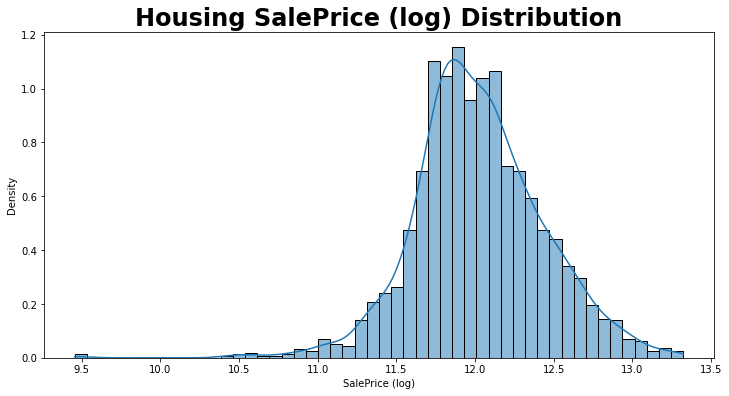

In [166]:
#taking the log of saleprice
train_data['saleprice_log'] = np.log(train_data['saleprice'])

#histogram of the saleprice_log
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(train_data.saleprice_log, stat='density',bins=50, kde=True, ax=ax)
plt.title('Housing SalePrice (log) Distribution', fontsize=24, fontweight='semibold')
plt.xlabel('SalePrice (log)');

In [167]:
# We now have a normal distribution 
train_data.saleprice_log.skew()

-0.14681576272177396

With a skewness of -0.14, we can assume a normal distribution. Here are our outliers (3 standard deviations above and bellow the mean)

In [168]:
#count of houses above 3 std of log saleprice
train_data.saleprice_log.loc[
    (train_data.saleprice_log > np.mean(train_data.saleprice_log) + 3 * np.std(train_data.saleprice_log))
].count()

4

Given a recent experience in real estate, I picked the following variables because I thought they would be interesting. A closer look at sales above normal (outliers) show that they all have a `saleprice` above $582k, square footage above 2300, a kitchen quality between `Good` and `Excelent`, and are in the `Northridge`, `Northridge Heights`, and `Stone Brook` neighborhoods. The `Stone Brook` house is close to a park (`condition` == `PosN`). No surprise they all have a quality rating of 9/10.

In [169]:
# houses above 3 std of log saleprice

train_data[['saleprice_log', 
            'saleprice', 
            'gr_liv_area', 
            'kitchen_qual',
            'ms_zoning', 
            'overall_qual', 
            'condition_1',
           'neighborhood']].loc[
    (train_data['saleprice_log'] > np.mean(train_data['saleprice_log']) +
                              3 * np.std(train_data['saleprice_log']))]

,saleprice_log,saleprice,gr_liv_area,kitchen_qual,ms_zoning,overall_qual,condition_1,neighborhood
1671,13.323927,611657,2364,Ex,RL,9,Norm,NridgHt
1692,13.278512,584500,3500,Ex,RL,9,Norm,NoRidge
1796,13.275828,582933,2822,Ex,RL,9,Norm,NridgHt
1964,13.290564,591587,2338,Gd,RL,9,PosN,StoneBr


In [170]:
# count of houses bellow 3 std of log saleprice
train_data.saleprice_log.loc[
    (train_data.saleprice_log < np.mean(train_data.saleprice_log) -
                              3 * np.std(train_data.saleprice_log))
].count()

10

Lower than normal sales occured mostly for houses near rail roads (`neighborhood` == 'IDOTRR') that were classified as either in the `Commercial` or `Agriculture` zoning area. Their saleprices were bellow $45k, their kitchen quality were between `fair` and `average` and had less than 1400 square feet. The quality of these properties are no more than 4/10.

In [171]:
train_data[['saleprice_log', 
            'saleprice', 
            'gr_liv_area', 
            'kitchen_qual',
            'ms_zoning', 
            'overall_qual', 
            'condition_1',
           'neighborhood']].loc[
    (train_data['saleprice_log'] < np.mean(train_data['saleprice_log']) -
                              3 * np.std(train_data['saleprice_log']))]

,saleprice_log,saleprice,gr_liv_area,kitchen_qual,ms_zoning,overall_qual,condition_1,neighborhood
103,10.691945,44000,797,TA,C (all),3,Norm,IDOTRR
183,9.480368,13100,733,Fa,A (agr),1,Norm,IDOTRR
408,10.596635,40000,1317,TA,C (all),4,Feedr,IDOTRR
1089,10.714418,45000,612,TA,RM,2,Norm,OldTown
1292,10.463103,35000,498,TA,RL,2,Feedr,Edwards
1309,10.460242,34900,720,TA,C (all),4,Norm,IDOTRR
1428,10.578980,39300,334,Fa,RL,1,Norm,BrkSide
1518,10.471950,35311,480,TA,C (all),2,Norm,IDOTRR
1564,10.542706,37900,968,TA,RM,3,Norm,OldTown
1628,9.456341,12789,832,TA,RM,2,Norm,OldTown


Let's visualize the saleprice by neighborhood

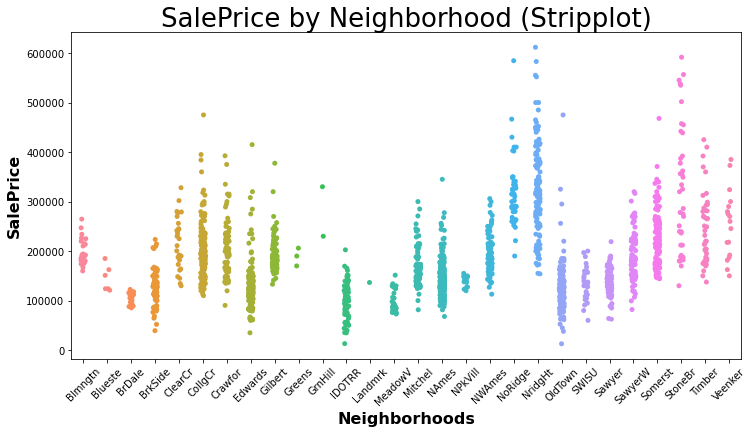

In [172]:
# Visual of neighborhood saleprices
# adapted from https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96

fig, ax = plt.subplots(figsize=(12,6))

sns.stripplot(x = train_data.neighborhood, y = train_data.saleprice, order = np.sort(train_data.neighborhood.unique()), ax=ax)
plt.title('SalePrice by Neighborhood (Stripplot)', fontsize=26)
plt.ylabel('SalePrice', fontsize=16, fontweight='semibold')
plt.xlabel('Neighborhoods', fontsize=16, fontweight='semibold')
plt.xticks(rotation=45)
plt.show()

Let's now group the neighborhoods into 4, based on the outlier values, the median, and the highest saleprice. The goal is to control for very low or very high (outliers) values without having to drop them. As a data scientist, I always want to keep an eye on the data at hand, avoiding as much as I can to drop any value. We can see, as expected that as the price increases, the overall quality also increases.

In [174]:
# grouping neighborhood into 4 sale price groups based on IQR, from very_low to high
train_data['neighborhood_cat'] = pd.cut(train_data['saleprice'], (0, 45001, 162500, 582000, 611657), 
                                             labels=['very_low', 'low', 'med', 'high'], ordered=True)

# grouping the neighborhood by sale price from very low to high
train_data[['neighborhood_cat', 'saleprice', 'overall_qual' ]].groupby(['neighborhood_cat']).median().sort_values(
    by='saleprice', ascending=False)

,saleprice,overall_qual
neighborhood_cat,,
high,588043.5,9.0
med,214000.0,7.0
low,130000.0,5.0
very_low,36605.5,2.0


Without a surprise, the overall quality tells us which group a house belongs to.

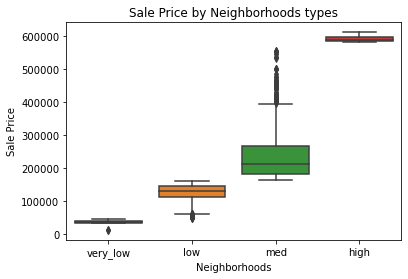

In [175]:
#plotting the boxplot of Sale Price by Neighborhoods types
x = train_data['neighborhood_cat']
y = train_data['saleprice']

sns.boxplot(x=x, y=y)
plt.xlabel('Neighborhoods')
plt.ylabel('Sale Price')
plt.title('Sale Price by Neighborhoods types');

Furthermore, we can notice that the most expensive houses have more than 2000 sf in ground living space, a garage area and an overall quality of at least 8.

In [115]:
# # looking at sales price against square footage and house quality
# train_data[['saleprice', 
#             'gr_liv_area', 
#             'garage_area', 
#             'total_bsmt_sf', 
#             '1st_flr_sf',
#            '2nd_flr_sf',
#            'overall_qual']
#           ].sort_values(
#     by='saleprice',ascending=False)[:10]

A Closer look at the relationship between SalePrice and Square Footage

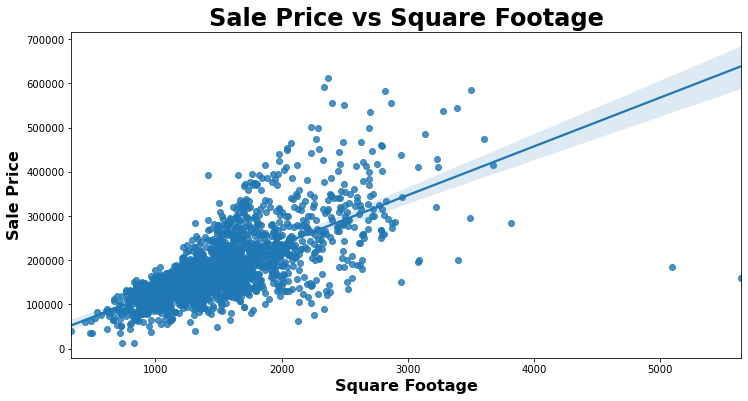

In [153]:
# Relationship between Sale Price and Square footage
# The larger the house, the higher the price, ceteris paribus

fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(x='gr_liv_area', y='saleprice', data=train_data, ax=ax)
plt.title('Sale Price vs Square Footage', fontsize=24, fontweight='semibold')
plt.ylabel('Sale Price', fontsize=16, fontweight='semibold')
plt.xlabel('Square Footage', fontsize=16, fontweight='semibold')
plt.show();

#### Dealing with missing values
To address missing values, we need to understand what they mean and how we can use them. Because we are looking at houses, missing values should tell us about what type of features are included in a house. For instance, if there is no pool, there won't be any value recorded in the variable `pool_qc`. In this data, only 9 houses have pools, so the remaining 2042 are missing. Another way to see this is by looking at the consitency of the missing values in the `garage` variables. They all have the same missing values of 114. 

In [10]:
# uncomment to see the count of missing values
# train_data.isna().sum().sort_values(ascending=False)[:30]

We'll fill in the missing values with the value `0`. We could have chosen to instead use the mean, median, the mode or nearest neighbor... but those imputations would create features in the houses that don't actually have them, which would have introduced bias in our model and shift our distributions. For example, if a house has no garage (missing), but we give it one because it's in a certain neighborhood where other houses have a pool. This will likely increase our predicted sales price. You can also think of it like this: you'are looking for a house with a garage, your friend tells you that he's selling a house with a garage but once you get there, surprise, there is no garage. Even if you're interested, would you purchase it at the same amount?

In [203]:
# filling the NA values with 0
for column in train_data.columns:
    if column in train_data.isna():
        train_data.replace(np.nan, 0, inplace=True)

train_data.isna().sum().sort_values(ascending=False)[:10]

sale_price_sf    0
bsmt_qual        0
roof_matl        0
exterior_1st     0
exterior_2nd     0
mas_vnr_type     0
mas_vnr_area     0
exter_qual       0
exter_cond       0
foundation       0
dtype: int64

#### Feature Engineering
Let's now create few more variables that will improve our model; one for the age of the house being sold, another one for the elapse time since the last renovation or addition occured, and one more for the price per square foot.

In [204]:
# create a column for the age of the house when sold  
train_data['house_age'] = train_data['yr_sold'] - train_data['year_built']
train_data['renovated'] = train_data['yr_sold'] - train_data['year_remod/add']
train_data['sale_price_sf'] = train_data.saleprice / train_data.gr_liv_area

train_data.loc[:,['house_age', 
                  'yr_sold', 
                  'year_built', 
                  'renovated', 
                  'year_remod/add',
                 'sale_price_sf']][:3]

,house_age,yr_sold,year_built,renovated,year_remod/add,sale_price_sf
0,34,2010,1976,5,2005,88.235294
1,13,2009,1996,12,1997,103.675778
2,57,2010,1953,3,2007,103.122044


We now need to create dummies for the non-numeric variables. This will allow us to capture information from other non numeric variables. Note that keeping onnly N-1 categories, we avoid some multicollinearity issues. We now have 257 columns.

In [205]:
# creating the dummy variables for the non numeric variables
train_data_dummies = pd.get_dummies(train_data, drop_first=True)

# first 5 rows
train_data_dummies.head()

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,neighborhood_cat_low,neighborhood_cat_med,neighborhood_cat_high
0,109,533352170,60,0.0,13517,6,8,1976,2005,289.0,...,0,0,0,0,0,0,1,1,0,0
1,544,531379050,60,43.0,11492,7,5,1996,1997,132.0,...,0,0,0,0,0,0,1,0,1,0
2,153,535304180,20,68.0,7922,5,7,1953,2007,0.0,...,0,0,0,0,0,0,1,1,0,0
3,318,916386060,60,73.0,9802,5,5,2006,2007,0.0,...,0,0,0,0,0,0,1,0,1,0
4,255,906425045,50,82.0,14235,6,8,1900,1993,0.0,...,0,0,0,0,0,0,1,1,0,0


Once we have all the columns, we can see the highest correlated values between sales price (our dependent variable) and the other numeric values

In [206]:
# computting the correlation matrix between price and other numeric variables

corr_matrix = train_data_dummies.corr()[['saleprice']].sort_values(
    by='saleprice', ascending=False)

Let's only look at the correlated values above 0.3 in absolute values. 

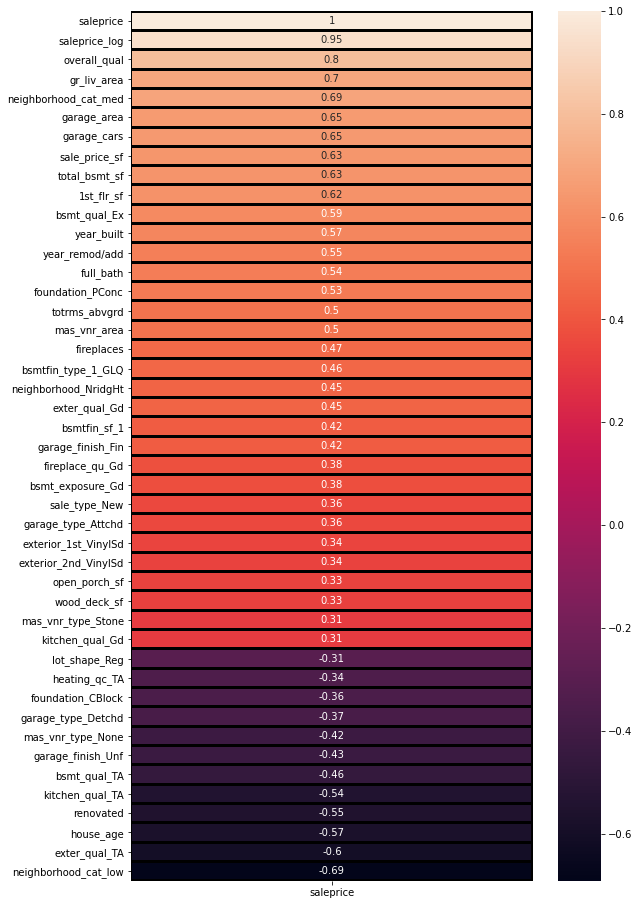

In [207]:
# list of variables with corr above 0.3 in absolute value
corr_matrix_30_plus = corr_matrix[corr_matrix['saleprice'].abs() >= 0.3]
# corr_matrix_30_plus.T.columns

# plotting the correlated variables with values above 0.3 (in absolute value) 
plt.figure(figsize=(9,16))
sns.heatmap(corr_matrix_30_plus,
           annot=True,
           linecolor='black',
           linewidths=2
           );

The corralation matrix confirms that the overall quality of the house, its square footage, the garage capacity and square footage are among the strongest (positive) predictors in a housing price. On the negative side of our correlation matrix, we see that houses with a price between $45k and $162.5k, the older the house, the longer it's been renovated, with an exterior and/or a kitchen quality rated typical/average have the lowest coefficient. As a reminder, the higher the correlation coefficient in the positive direction, the more likely a feature will increase the selling price. One the other hand, the more negative the correlation coeficient, the more likely the selling price will go down. Let's filter only those columns.

In [208]:
# correlation columns
corr_matrix_30_plus_cols = list(corr_matrix_30_plus.T.columns)
corr_matrix_30_plus_no_dummies_cols = train_data_dummies[train_data_dummies[corr_matrix_30_plus_cols].abs() > 1].dropna(axis=1, thresh=0.95).columns

# filtering out the dummies
train_data_dummies[corr_matrix_30_plus_no_dummies_cols]

,overall_qual,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,fireplaces,garage_cars,garage_area,wood_deck_sf,open_porch_sf,saleprice,saleprice_log,house_age,renovated,sale_price_sf
0,6,1976,2005,289.0,533.0,725.0,725,1479,2,6,0,2.0,475.0,0,44,130500,11.779129,34,5,88.235294
1,7,1996,1997,132.0,637.0,913.0,913,2122,2,8,1,2.0,559.0,0,74,220000,12.301383,13,12,103.675778
2,5,1953,2007,0.0,731.0,1057.0,1057,1057,1,5,0,1.0,246.0,0,52,109000,11.599103,57,3,103.122044
3,5,2006,2007,0.0,0.0,384.0,744,1444,2,7,0,2.0,400.0,100,0,174000,12.066811,4,3,120.498615
4,6,1900,1993,0.0,0.0,676.0,831,1445,2,6,0,2.0,484.0,0,59,138500,11.838626,110,17,95.847751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,2007,2007,0.0,1011.0,1884.0,1728,1728,2,7,1,2.0,520.0,0,276,298751,12.607366,1,1,172.888310
2047,4,1940,1950,0.0,262.0,861.0,861,861,1,4,0,2.0,539.0,158,0,82500,11.320554,69,59,95.818815
2048,6,1928,1950,0.0,0.0,896.0,1172,1913,1,9,1,2.0,342.0,0,0,177000,12.083905,81,59,92.524830
2049,4,1956,1956,0.0,155.0,1200.0,1200,1200,1,6,2,1.0,294.0,0,189,144000,11.877569,53,53,120.000000


The distributions bellow show that the relationship between saleprice and some of the highest correlated variables seem to be between linear and a polynomial of degree 2. In other word, the distributions look like either a straight line or a curve. This information will help us determine what models that we'll use.

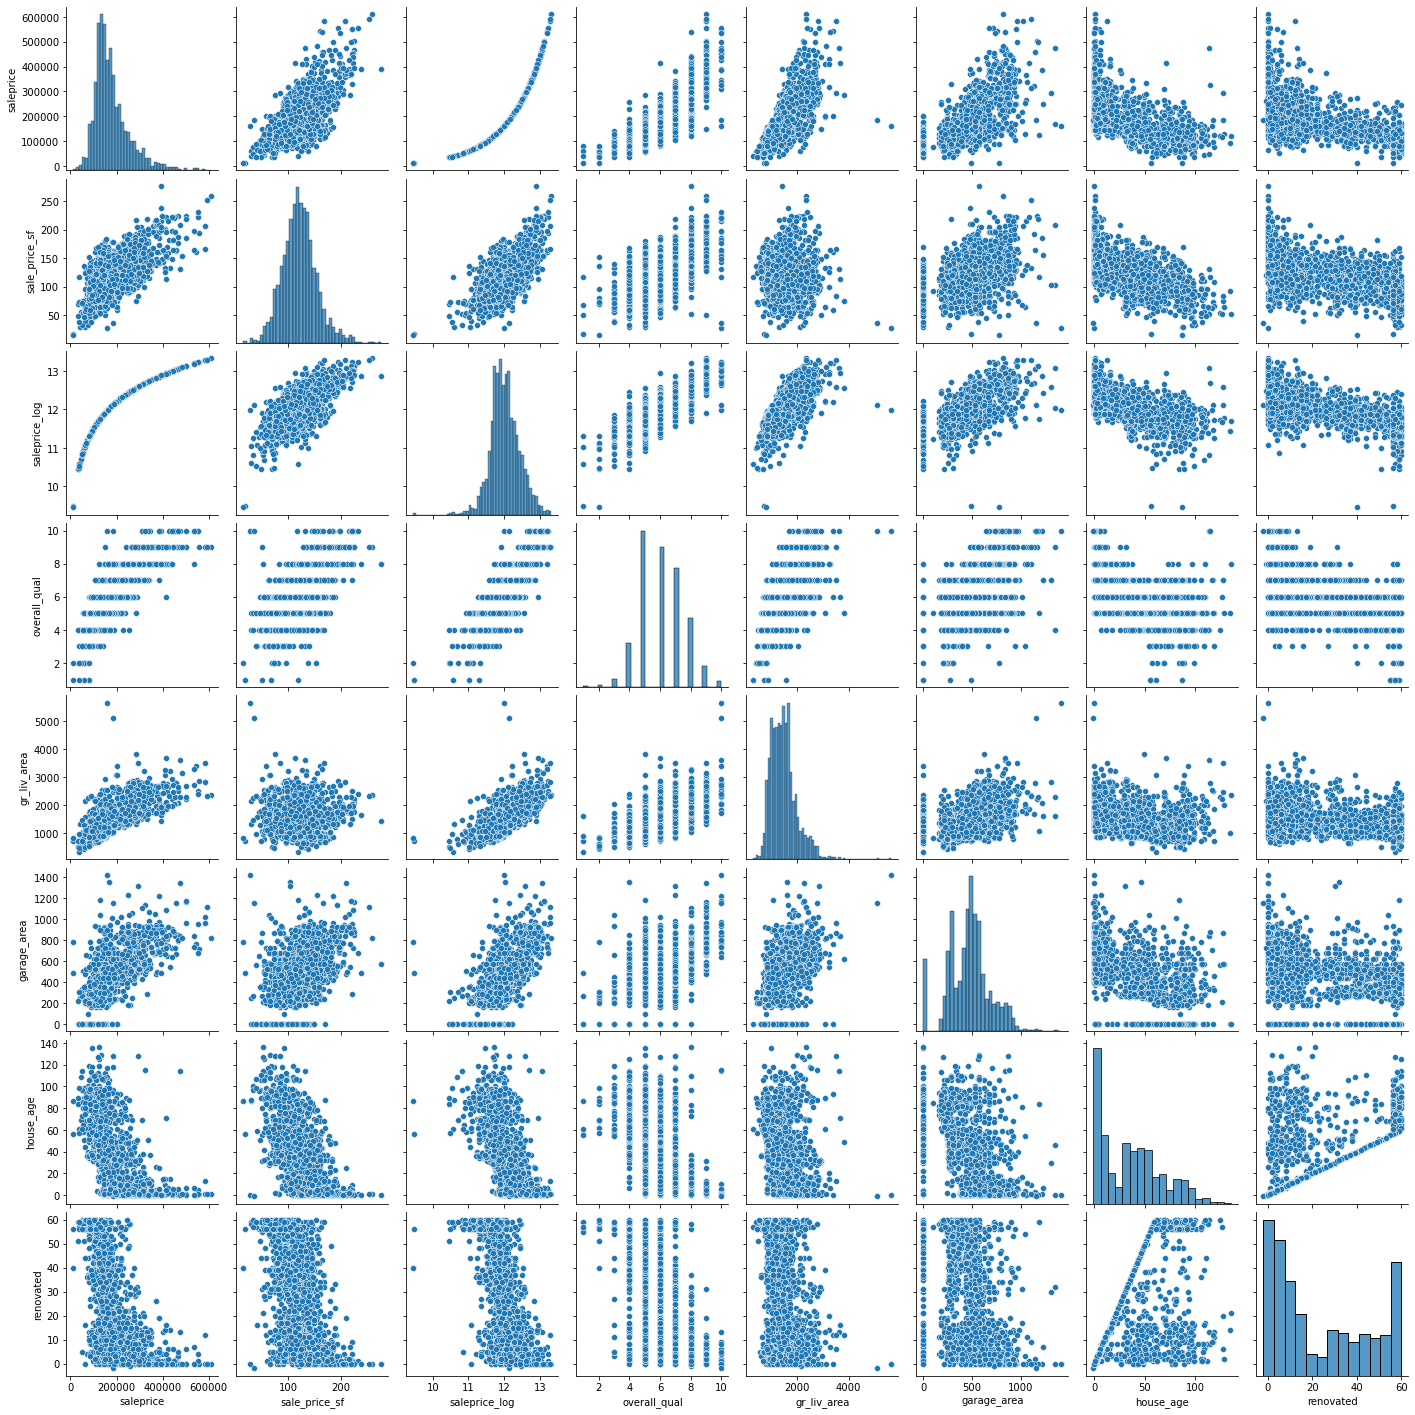

In [209]:
# plotting the Sale Price against some of the highest correlated variables
sns.pairplot(train_data_dummies[['saleprice', 'sale_price_sf', 'saleprice_log',
                                 'overall_qual', 'gr_liv_area',
                                'garage_area','house_age', 'renovated'
                                ]]);

### Modeling

For our modeling part, our initial model will be the the OLS regression since most of our variables have a fairly linear relationship. As we can make our model more complexe (by taking a polynomial of degree two), it might increase our accuracy but will likely lead to overfitting issues given that we have over 200 variables. To deal with that we'll use a LassoCV, and RidgeCV regression models. Let's create our functions and set up our X and Y variables.

In [266]:
# creating X and Y variables for the prediction model
X = train_data_dummies.drop(['saleprice', 'saleprice_log'], axis=1)

y = train_data_dummies['saleprice']
y_log = train_data_dummies['saleprice_log']

In [267]:
#creating a testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.33, random_state=42)

# scaling the data
print('scaling...')
sc = StandardScaler()
Z_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
Z_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
print('done!')

scaling...
done!


The fact that we have a significant difference between the train and the test score in the OLS is a signal that we're overfitting. Notice how large is the RMSE! With RidgeCv and LassoCV we don't have that problem though Lasso seems to perform better.

In [268]:
# Create a list of classifiers with their default parameters. This list will be used to fit the models using for loop
regressors = [LinearRegression(),
              RidgeCV(alphas=np.logspace(0, 5, 100), scoring='r2', cv=5), 
              LassoCV(alphas=np.logspace(-3, 0 , 100), cv=5, tol= 0.01)]

# Create a list of names for the regressors created above. This will be used to print their respective accuracies
regressor_names = ['LinearRegression',
                   'RidgeCV', 
                   'LassoCV']

# Use a for loop to iterate over the classifiers and classifiers_names lists to create and fit the models
for regressor, regressor_name in zip(regressors, regressor_names) :
    # Creating the model
    reg = regressor
    
    # Fitting the model
    reg.fit(Z_train, y_train)
    
    #predictions
    pred_train = reg.predict(Z_train)
    pred_test = reg.predict(Z_test)
    
    #scores
    print()
    print(f' {regressor_name} '.center(18, "="))
    print(f'train scores: {(reg.score(Z_train, y_train))}')
    print(f'rmse_train: {mean_squared_error(y_train, pred_train, squared=False)}')
    print()
    print(f'test score: {reg.score(Z_test, y_test)}')
    print(f'root mean squared: {mean_squared_error(y_test, pred_test, squared=False)}')


 LinearRegression 
train scores: 0.9858803000945411
rmse_train: 0.04880195658294201

test score: -1.3533228156285532e+18
root mean squared: 479378486.2336245

==== RidgeCV =====
train scores: 0.983200904258603
rmse_train: 0.053231346707447315

test score: 0.958574715011035
root mean squared: 0.08387076229123587

==== LassoCV =====
train scores: 0.9586075665388868
rmse_train: 0.08355741207667457

test score: 0.9470954900566567
root mean squared: 0.09478163275058393


Next steps will be to check the regression assumptions, and interpret the results, which I'm currently working on. Check back soon!